In this chapter, we will learn how to:

• Obtain unbiased estimates of a model's performance

• Diagnose the common problems of machine learning algorithms

• Fine-tune machine learning models

• Evaluate predictive models using different performance metrics


In [1]:
import pandas as pd
from sklearn.cross_validation import train_test_split
import numpy as np
import matplotlib.pyplot as plt


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',header=None)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Using LabelEncoder, we transform the class labels from their original string representation
(M and B) into integers:

In [4]:
from sklearn.preprocessing import LabelEncoder
X = df.loc[:,2:].values
y = df.loc[:,1].values
le = LabelEncoder()
y = le.fit_transform(y)

In [5]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20, random_state=1)

# Combining transformers and estimators in a Pipeline
In the previous chapter, you learned that many learning algorithms require input features on the same scale for optimal performance. Thus, we need to standardize the columns in the Breast Cancer Wisconsin dataset before we can feed them to a linear classi er, such as logistic regression. Furthermore, let's assume that we want to compress our data from the initial 30 dimensions onto a lower two-dimensional subspace via principal component analysis (PCA), a feature extraction technique for dimensionality reduction that we introduced in Chapter 5, Compressing Data via Dimensionality Reduction. Instead of going through the  tting and transformation steps for the training and test dataset separately, we can chain the StandardScaler, PCA, and LogisticRegression objects in a pipeline:

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [7]:
pipe_lr = Pipeline([('scl', StandardScaler()),('pca', PCA(n_components=2)),('lr',LogisticRegression(random_state=1))])
pipe_lr.fit(X_train,y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.947


The intermediate steps in a pipeline constitute scikit-learn transformers, and the
last step is an estimator. In the preceding code example, we built a pipeline that consisted of two intermediate steps, a StandardScaler and a PCA transformer, and a logistic regression classi er as a  nal estimator. When we executed the fit method on the pipeline pipe_lr, the StandardScaler performed fit and transform on the training data, and the transformed training data was then passed onto the next object in the pipeline, the PCA. Similar to the previous step, PCA also executed fit and transform on the scaled input data and passed it to the  nal element of the pipeline, the estimator. We should note that there is no limit to the number of intermediate steps in this pipeline. The concept of how pipelines work is summarized in the following  gure:

### The holdout method

A better way of using the holdout method for model selection is to separate the data into three parts: a training set, a validation set, and a test set. The training set is used to  t the different models, and the performance on the validation set is then used for the model selection. The advantage of having a test set that the model hasn't seen before during the training and model selection steps is that we can obtain a less biased estimate of its ability to generalize to new data

### The K-fold cross-validation
In k-fold cross-validation, we randomly split the training dataset into k folds without replacement, where k −1 folds are used for the model training and one fold is used for testing. This procedure is repeated k times so that we obtain k models and performance estimates.

In [8]:
from sklearn.cross_validation import StratifiedKFold
kfold = StratifiedKFold(y=y_train, n_folds = 10, random_state = 1)
scores = []
for k, (train,test) in enumerate(kfold):
    pipe_lr.fit(X_train[train],y_train[train])
    score = pipe_lr.score(X_train[test],y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))

Fold: 1, Class dist.: [256 153], Acc: 0.891
Fold: 2, Class dist.: [256 153], Acc: 0.978
Fold: 3, Class dist.: [256 153], Acc: 0.978
Fold: 4, Class dist.: [256 153], Acc: 0.913
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.978
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.956
Fold: 9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.956


In [9]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.029


Although the previous code example was useful to illustrate how k-fold cross-validation works, scikit-learn also implements a k-fold cross-validation scorer, which allows us to evaluate our model using strati ed k-fold cross-validation more ef ciently

In [10]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(estimator=pipe_lr, X = X_train, y = y_train, cv=10,n_jobs=1 )
print('CV accuracy Scores %s' % scores)

CV accuracy Scores [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]


An extremely useful feature of the cross_val_score approach is that we can distribute the evaluation of the different folds across multiple CPUs on our machine. If we set the n_jobs parameter to 1, only one CPU will be used to evaluate the performances just like in our StratifiedKFold example previously. However, by setting n_jobs=2 we could distribute the 10 rounds of cross-validation to two CPUs (if available on our machine), and by setting n_jobs=-1, we can use all available CPUs on our machine to do the computation in parallel.


## Diagnosing bias and variance problems with learning curves

If a model is too complex for a given training dataset—there are too many degrees
of freedom or parameters in this model—the model tends to over t the training
data and does not generalize well to unseen data. Often, it can help to collect more training samples to reduce the degree of over tting. However, in practice, it can often be very expensive or simply not feasible to collect more data. By plotting the model training and validation accuracies as functions of the training set size, we can easily detect whether the model suffers from high variance or high bias, and whether the collection of more data could help to address this problem.But before we discuss how to plot learning curves in sckit-learn


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


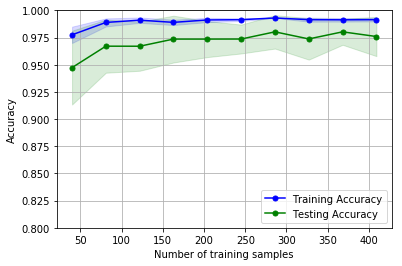

In [11]:
from sklearn.learning_curve import learning_curve
pipe_lr = Pipeline([('scl',StandardScaler()), ('clf', LogisticRegression(penalty = 'l2', random_state=0))])
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y= y_train, train_sizes=np.linspace(0.1,1.0,10.0), cv=10, n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='o', markersize=5, label='Testing Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()


Via the train_sizes parameter in the learning_curve function, we can control the absolute or relative number of training samples that are used to generate the learning curves. Here, we set train_sizes=np.linspace(0.1, 1.0, 10) to use 10 evenly spaced relative intervals for the training set sizes. By default, the learning_curve function uses strati ed k-fold cross-validation to calculate the cross-validation accuracy, and we set k =10 via the cv parameter. Then, we simply calculate the average accuracies from the returned cross-validated training and test scores for the different sizes of the training set, which we plotted using matplotlib's plot function. Furthermore, we add the standard deviation of the average accuracies to the plot using the fill_between function to indicate the variance of the estimate.

### Addressing overfitting and underfitting with validation curves

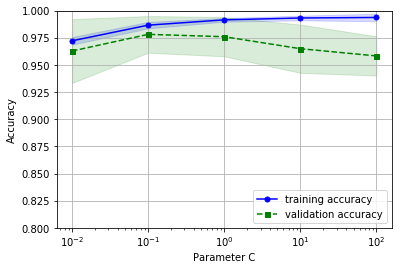

In [12]:
from sklearn.learning_curve import validation_curve
param_range = [0.01,0.1,1,10,100]
train_scores, test_scores = validation_curve(estimator = pipe_lr, X=X_train, y=y_train, param_name = 'clf__C', param_range=param_range, cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean,color='blue', marker='o',markersize=5,label='training accuracy')
plt.fill_between(param_range, train_mean + train_std,train_mean - train_std, alpha=0.15,color='blue')
plt.plot(param_range, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
plt.fill_between(param_range,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()

Similar to the learning_curve function, the validation_curve function uses strati ed k-fold cross-validation by default to estimate the performance of the model if we are using algorithms for classi cation. Inside the validation_curve function, we speci ed the parameter that we wanted to evaluate. In this case, it is C, the inverse regularization parameter of the LogisticRegression classi er, which we wrote as 'clf__C' to access the LogisticRegression object inside the scikit-learn pipeline for a speci ed value range that we set via the param_range parameter. Similar to the learning curve example in the previous section, we plotted the average training and cross-validation accuracies and the corresponding standard deviations.
Although the differences in the accuracy for varying values of C are subtle, we can see that the model slightly under ts the data when we increase the regularization strength (small values of C). However, for large values of C, it means lowering the strength of regularization, so the model tends to slightly over t the data. In this case, the sweet spot appears to be around C=0.1.

## Fine-tuning machine learning models via grid search
In machine learning, we have two types of parameters: those that are learned from the training data, for example, the weights in logistic regression, and the parameters of a learning algorithm that are optimized separately. The latter are the tuning parameters, also called hyperparameters, of a model, for example, the regularization parameter in logistic regression or the depth parameter of a decision tree.
In the previous section, we used validation curves to improve the performance of a model by tuning one of its hyperparameters. In this section, we will take a look at a powerful hyperparameter optimization technique called grid search that can further help to improve the performance of a model by  nding the optimal combination of hyperparameter values.

### Tuning hyperparameters via grid search

In [13]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
pipe_svc = Pipeline([('cls', StandardScaler()), ('clf', SVC(random_state=1))])
param_range = [0.0001,0.001,0.01,0.1,1,10,100,1000]
param_grid = [{'clf__C' : param_range,
              'clf__kernel': ['linear']},
             {'clf__C': param_range,
             'clf__gamma': param_range,
             'clf__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid,scoring='accuracy', cv=10,n_jobs=-1)
gs.fit(X_train,y_train)
print(gs.best_score_)
print(gs.best_params_)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


0.978021978021978
{'clf__C': 0.1, 'clf__kernel': 'linear'}


Using the preceding code, we initialized a GridSearchCV object from the sklearn.grid_search module to train and tune a support vector machine (SVM) pipeline. We set the param_grid parameter of GridSearchCV to a list of dictionaries to specify the parameters that we'd want to tune. For the linear SVM, we only evaluated the inverse regularization parameter C; for the RBF kernel SVM, we tuned both the C and gamma parameter. Note that the gamma parameter is speci c to kernel SVMs. After we used the training data to perform the grid search, we obtained the score of the best-performing model via the best_score_ attribute and looked at its parameters, that can be accessed via the best_params_ attribute. In this particular case, the linear SVM model with 'clf__C'= 0.1' yielded the best k-fold cross- validation accuracy: 97.8 percent.

Finally, we will use the independent test dataset to estimate the performance of the best selected model, which is available via the best_estimator_ attribute of the GridSearchCV object:

In [14]:
clf = gs.best_estimator_
clf.fit(X_train,y_train)
print('Test score : %.3f' %clf.score(X_test,y_test))

Test score : 0.965


Although grid search is a powerful approach for  nding the optimal set of parameters, the evaluation of all possible parameter combinations is also computationally very expensive. An alternative approach to sampling different parameter combinations using scikit-learn is randomized search. Using the RandomizedSearchCV class in scikit-learn, we can draw random parameter combinations from sampling distributions with a speci ed budget. More details and examples for its usage can be found
at http://scikit-learn.org/stable/modules/grid_search.html #randomized-parameter-optimization

In [15]:
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=2, n_jobs=-1)
scores = cross_val_score(gs, X_train,y_train, scoring='accuracy', cv=5)
print('CV accuracy %.3f +- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy 0.965 +- 0.025


The returned average cross-validation accuracy gives us a good estimate of what
to expect if we tune the hyperparameters of a model and then use it on unseen data. For example, we can use the nested cross-validation approach to compare an
SVM model to a simple decision tree classi er; for simplicity, we will only tune
its depth parameter:

In [16]:
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=1), param_grid=[{'max_depth' : [1,2,3,4,5,6,7,None]}], scoring='accuracy', cv = 5)
scores = cross_val_score(gs, X_train,y_train, scoring='accuracy', cv=2)
print('CV accuracy %.3f +- %.3f' % (np.mean(scores), np.std(scores)))



CV accuracy 0.912 +- 0.009


As we can see here, the nested cross-validation performance of the SVM
model (97.8 percent) is notably better than the performance of the decision tree (90.8 percent). Thus, we'd expect that it might be the better choice for classifying new data that comes from the same population as this particular dataset.

## Looking at different performance evaluation metrics
### Reading a confusion matrix

In [17]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train,y_train)
y_pred = pipe_svc.predict(X_test)
conf_mat = confusion_matrix(y_true = y_test, y_pred= y_pred)
print(conf_mat)


[[71  1]
 [ 2 40]]


### Optimizing the precision and recall of a classi cation model

In [19]:
from sklearn.metrics import precision_score,recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964
